In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

c:\Users\USER\OneDrive - UNIVERSITAS INDONESIA\COOLYEAH\smt 8\tugas akhir\topic-modelling\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_01 = pd.read_csv('data/stemmed_merged_kubu_01.csv')
df_02 = pd.read_csv('data/stemmed_merged_kubu_02.csv')
df_03 = pd.read_csv('data/stemmed_merged_kubu_03.csv')

In [3]:
# Indonesian stopwords plus election-specific terms
indo_stopwords = [
    "yang", "dan", "di", "dengan", "untuk", "dari", "ke", "pada", "ini", "itu",
    "atau", "ada", "juga", "dalam", "saya", "kamu", "anda", "mereka", "kita", "kami",
    "dia", "nya", "adalah", "akan", "oleh", "seperti", "telah", "sudah", "bisa", "dapat",
    "tidak", "tak", "jangan", "ya", "via", "yg", "dgn", "utk", "dr", "pd", "dlm", "sdh", "tdk",
    # Election-specific terms that appear everywhere
    "anies", "baswedan", "muhaimin", "iskandar", "cak", "imin", "gus", "presiden", 
    "wakil", "calon", "ri", "mas", "pilih", "santri"
]

In [ ]:
# Configure a more targeted vectorizer for Indonesian political content
from sklearn.cluster import DBSCAN


vectorizer = CountVectorizer(
    stop_words=indo_stopwords,
    ngram_range=(1, 3),  # Keep bigrams and trigrams for political phrases
    min_df=5,            # Lower threshold to capture more specific topics
    max_df=0.7           # Stricter upper bound to remove very common terms
)

# Configure UMAP for better clustering of political content
umap_model = UMAP(
    n_neighbors=15,      # Smaller neighborhood for more specific clusters
    n_components=5,      
    min_dist=0.0,        # Adjusted for better separation
    metric='cosine',
    random_state=42
)

# More sensitive clustering for political topics
hdbscan_model = HDBSCAN(
    min_cluster_size=10,  # Smaller clusters to capture specific campaign themes
    min_samples=3,       # More lenient sample requirement
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Improved c-TF-IDF weighting
ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=True,
    bm25_weighting=True
)

embedding_model = SentenceTransformer(
    'distiluse-base-multilingual-cased-v1'
)

# Configure BERTopic for Indonesian political content
topic_model = BERTopic(
    language="multilingual",  # Keep multilingual for Indonesian
    calculate_probabilities=True,
    verbose=True,
    nr_topics=15,             # Reduced from 15 to get more focused topics
    min_topic_size=5,         # Smaller topics to capture campaign themes
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model,
)

# Fit the model
topics, probs = topic_model.fit_transform(df_01['full_text'].tolist())

2025-05-22 01:56:29,030 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 934/934 [05:15<00:00,  2.96it/s]
2025-05-22 02:01:45,160 - BERTopic - Embedding - Completed ✓
2025-05-22 02:01:45,161 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-22 02:02:06,330 - BERTopic - Dimensionality - Completed ✓
2025-05-22 02:02:06,331 - BERTopic - Cluster - Start clustering the reduced embeddings


In [12]:
# Generate more intuitive topic labels
topic_labels = {}
for topic_id in topic_model.get_topic_info()["Topic"]:
    if topic_id == -1:
        topic_labels[topic_id] = "Miscellaneous"
        continue
        
    # Get top words
    words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
    
    # Map topics to campaign themes based on keywords
    if any(term in words for term in ["palestina", "doa", "gelar", "bukittinggi"]):
        topic_labels[topic_id] = "Kampanye Palestina"
    elif any(term in words for term in ["aceh", "warga", "sambut", "bandara", "kedatagan"]):
        topic_labels[topic_id] = "Kunjungan ke Aceh"
    elif any(term in words for term in ["sumbar", "sumatra", "barat", "safari"]):
        topic_labels[topic_id] = "Kampanye Sumatra Barat"
    elif any(term in words for term in ["adil", "makmur", "sejahtera", "rakyat"]):
        topic_labels[topic_id] = "Visi Keadilan & Kemakmuran"
    elif any(term in words for term in ["menang", "indonesia", "senang", "bismillah"]):
        topic_labels[topic_id] = "Dukungan Kemenangan"
    elif any(term in words for term in ["pesantren", "santri", "tenanan", "kiai"]):
        topic_labels[topic_id] = "Dukungan Pesantren & Santri"
    elif any(term in words for term in ["partai", "bangkit", "bangsa"]):
        topic_labels[topic_id] = "Dukungan Partai Politik"
    else:
        # Use top 3 words as label for other topics
        topic_labels[topic_id] = " & ".join(words[:3])

# Apply custom labels
topic_model.set_topic_labels(topic_labels)


Improved Topic Information:
   Topic  Count                                               Name  \
0     -1  10214                           -1_bicara_suka_hati_moga   
1      0   9034                         0_suara_buzzer_agama_01 01   
2      1   4102                   1_demokrasi_video_politik_partai   
3      2   3719  2_makmur_adil makmur_indonesia adil_indonesia ...   
4      3   1470                     3_debat_kritik_dialog_komentar   
5      4    408                4_twitter_media_media sosial_sosial   
6      5    330                  5_program_gratis_makan_program 01   
7      6    214      6_pintar_01 pintar_orang pintar_pintar bicara   
8      7    150                           7_merdeka_aksi_free_bela   
9      8     84             8_strategi_orang dekat_jauh_tim sukses   

                          CustomName  \
0                      Miscellaneous   
1             suara & buzzer & agama   
2            Dukungan Partai Politik   
3         Visi Keadilan & Kemakmuran   


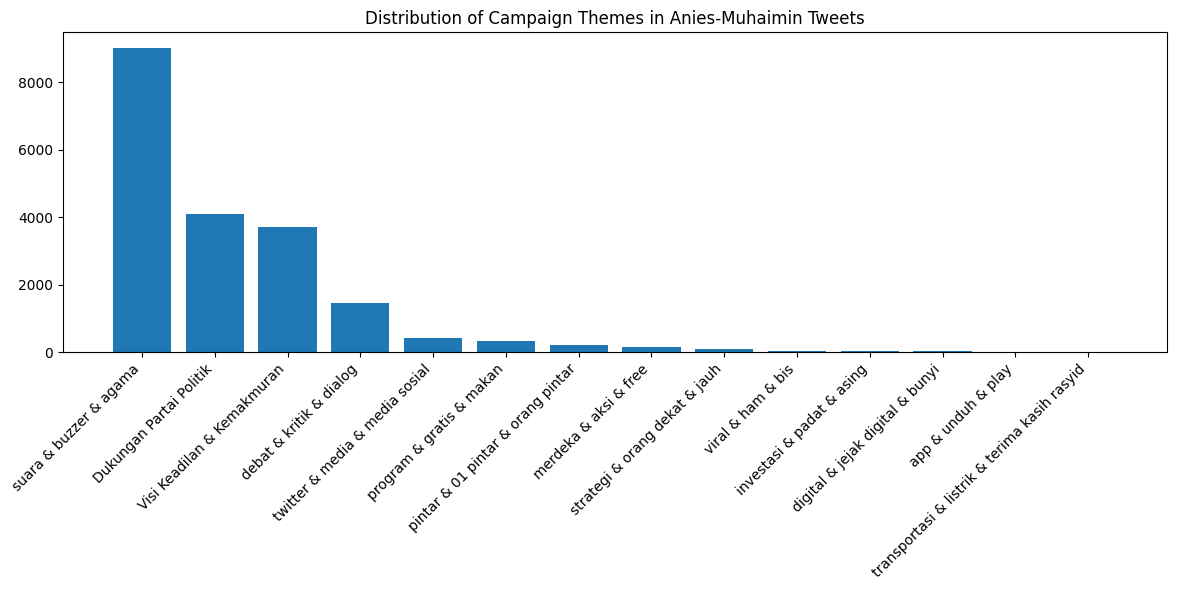

In [13]:
# Get the improved topic information
topic_info = topic_model.get_topic_info()
print("\nImproved Topic Information:")
print(topic_info.head(10))

# Print topics with their new labels
print("\nCampaign Themes for Anies-Muhaimin:")
for index, row in topic_info.iterrows():
    if row["Topic"] != -1:  # Skip outlier topic
        topic_id = row["Topic"]
        words = [word[0] for word in topic_model.get_topic(topic_id)[:8]]
        print(f"Theme: {row['Name']}")
        print(f"Keywords: {', '.join(words)}")
        print(f"Document count: {row['Count']}")
        print("-" * 50)

# Create a topic distribution visualization
plt.figure(figsize=(12, 6))
topic_counts = topic_info[topic_info["Topic"] != -1]["Count"]
topic_names = [label for topic, label in topic_labels.items() if topic != -1]
plt.bar(topic_names, topic_counts)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Campaign Themes in Anies-Muhaimin Tweets")
plt.tight_layout()
plt.show()

In [7]:
from wordcloud import WordCloud
import seaborn as sns

In [8]:
# Create topic distribution from the existing topic_info
topic_distribution = topic_info.set_index("Topic")["Count"]

# Get representative documents for key campaign themes
print("\nRepresentative tweets for key campaign themes:")
key_topics = [t for t in topic_distribution.index if t != -1][:5]

for topic_id in key_topics:
    theme_name = topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic_id, "Name"].values[0]
    print(f"\n--- Theme: {theme_name} ---")
    rep_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(rep_docs[:3]):
        print(f"{i+1}. {doc[:200]}...")


Representative tweets for key campaign themes:

--- Theme: 0_suara_buzzer_agama_01 01 ---
1. bukti surabaya kota pahlawan moga desakanies antar anies isi semangat nyali dahulu milik lawan jujur down dengar obrol warung kopi 01 gembos mungut suara si komisi pemelihan...
2. bikin kacau orang orang kayak bikin janji janji manis masuk akal terima gilir pasang calon langsung kasih gebrak nyata kritik bahan bakar minyak gratis orang tolol percaya buzzer 01 diam salam malaika...
3. oi tolol moga berani mempertanggungjawabkan buat mu suka sebar isu bohong benci musuh suka bikin blunder ngomong-ngomong kasihan anies baswedan langsung rugi gara gara benalu parasit tumpang gelap kub...

--- Theme: 1_demokrasi_video_politik_partai ---
1. koalisi ubah umum agus harimurti yudhoyono wakil otomatis demokrat pergi koalisi anies gagal nasional demokrat partai adil sejahtera cari partai ganti demokrat partai gabung koalisi...
2. partai bangkit bangsa partai adil sejahtera catat cacat sejarah tanda nu ja